# Segmentation using Images.jl
Image Segmentation is the process of partitioning the image into regions that have similar attributes. Image segmentation has various applications e.g, medical image segmentation, image compression and is used as a preprocessing step in higher level vision tasks like object detection and optical flow.

Let's see an example for segmenting vegetables image. We will be using unseeded region growing for segmentation example below.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `C:\Users\lenono\Documents\StudyCode\JuliaCon23_ImageProcessingWorkshop`


In [2]:
using Images, TestImages

After loading Images.jl which provides segmentation algorithms through ImageSegmentation.jl. We load `peppers_color` from TestImages.jl and resize it to (256,256) using imresize()

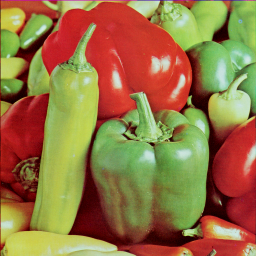

In [3]:
img = testimage("peppers_color")
img = imresize(img, (256,256))

Let's apply unseeded_region_growing to the image to paritioning different portions of the image.

In [4]:
seg = unseeded_region_growing(img, 0.3)

Segmented Image with:
  labels map: 256×256 Matrix{Int64}
  number of labels: 16

These Algorithms return segmented_image which has various interesting elements which are discussed below:

In [5]:
seg.image_indexmap

256×256 Matrix{Int64}:
  1   2   2  2  2   2  13  13  13  13  …  14  11  11  11  11  13  13  13  13
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2  …   1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   4  4  4   4   4   4   4   4      1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4  …   1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4      1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4      1   1   1 

`seg.image_indexmap` returns a matrix which is same size as original image and each pixel has a label assigned to it. Similar pixels are assigned same labels based on the threshold.

In [6]:
seg.segment_labels

16-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

`seg.segment_labels` lists all the labels that are present in `seg.image_indexmap`

In [7]:
seg.segment_means

Dict{Int64, RGB{Float32}} with 16 entries:
  5  => RGB{Float32}(0.538204,0.128335,0.115341)
  16 => RGB{Float32}(0.493705,0.479257,0.712074)
  12 => RGB{Float32}(0.512661,0.478354,0.217188)
  8  => RGB{Float32}(0.666029,0.735862,0.338502)
  1  => RGB{Float32}(0.534068,0.685896,0.330316)
  6  => RGB{Float32}(0.321681,0.091574,0.0652107)
  11 => RGB{Float32}(0.797436,0.569053,0.398486)
  9  => RGB{Float32}(0.745169,0.841813,0.722715)
  14 => RGB{Float32}(0.428316,0.312803,0.526067)
  3  => RGB{Float32}(0.191408,0.0172013,0.00855594)
  7  => RGB{Float32}(0.474783,0.594287,0.3038)
  4  => RGB{Float32}(0.691447,0.789018,0.446015)
  13 => RGB{Float32}(0.724869,0.196844,0.484409)
  15 => RGB{Float32}(0.760866,0.391585,0.611356)
  2  => RGB{Float32}(0.74125,0.191528,0.155143)
  10 => RGB{Float32}(0.495846,0.263382,0.12812)

All available pixels have a label given to them by the segmentation algorithm and all pixel with same label are used to calculate the mean color and in `seg.segment_means` is of type `Dict{Int, Colorant}` which is label->mean_color

In [10]:
seg.segment_pixel_count

Dict{Int64, Int64} with 16 entries:
  5  => 7128
  16 => 19
  12 => 457
  8  => 11033
  1  => 7508
  6  => 4520
  11 => 1031
  9  => 3307
  14 => 68
  3  => 1755
  7  => 10978
  4  => 2419
  13 => 82
  15 => 48
  2  => 14069
  10 => 1114

Each label has a certain number of pixel associated to them, `seg.segment_pixel_count` gives that count with label->count.

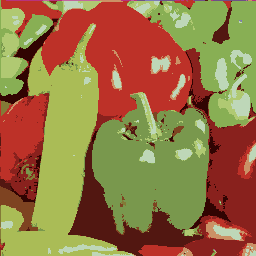

In [11]:
img_up = zeros(RGB, (256,256));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]]
end
img_up

As we can see, segmentation algorithm segmented the image into multiple regions and each region had similiar properties.

# Algorithms


### Seeded Region Growing
Seeded region growing segments an image with respect to some user-defined seeds. Each seed is a (position, label) tuple, where position is a CartesianIndex and label is a positive integer.

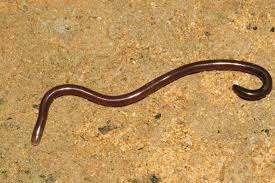

In [16]:
seeds = [(CartesianIndex(104, 48), 1), (CartesianIndex( 49, 40), 1),
                (CartesianIndex( 72,131), 1), (CartesianIndex(109,217), 1),
                (CartesianIndex( 28, 87), 2), (CartesianIndex( 64,201), 2),
                (CartesianIndex(104, 72), 2), (CartesianIndex( 86,138), 2)];
img = load("assets/worm.jpg")

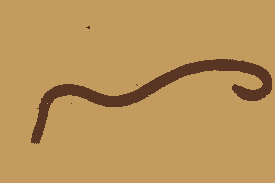

In [18]:
seg = seeded_region_growing(img, seeds)

img_up = zeros(RGB, (183,275));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]]
end
img_up

## Unseeded Region Growing
This algorithm is similar to Seeded Region Growing but does not require any prior information about the seed points.

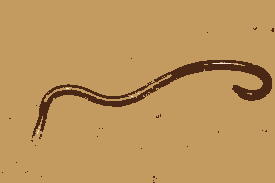

In [28]:
seg = unseeded_region_growing(img, 0.6)
img_up = zeros(RGB, (183,275));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]]
end
img_up

### Felzenswalb's Region Merging Algorithm
This algorithm operates on a Region Adjacency Graph (RAG). Each pixel/region is a node in the graph and adjacent pixels/regions have edges between them with weight measuring the dissimilarity between pixels/regions. The algorithm repeatedly merges similar regions till we get the final segmentation. It efficiently computes oversegmented “superpixels” in an image.

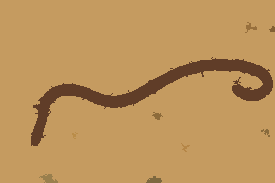

In [37]:
seg = felzenszwalb(img, 30, 15) 
img_up = zeros(RGB, (183,275));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]]
end
img_up

### MeanShift Segmentation
MeanShift is a clustering technique. Its primary advantages are that it doesn't assume a prior on the shape of the cluster (e.g, gaussian for k-means) and we don't need to know the number of clusters beforehand. The algorithm doesn't scale well with size of image.

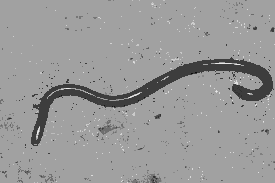

In [39]:
seg = meanshift(Gray.(img), 16, 8/255)
img_up = zeros(RGB, (183,275));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]]
end
img_up

## WaterShed Segmentation
The watershed algorithm treats an image as a topographic surface where bright pixels correspond to peaks and dark pixels correspond to valleys. The algorithm starts flooding from valleys (local minima) of this topographic surface and region boundaries are formed when water from different sources merge. If the image is noisy, this approach leads to oversegmetation. 


In [85]:
img = testimage("blobs")
@info size(img)
bw = Gray.(img) .> 0.5;
dist = 1 .- distance_transform(feature_transform(bw));
markers = label_components(dist .< 0.5);
seg = watershed(dist, markers)

[ Info: (254, 256)


Segmented Image with:
  labels map: 254×256 Matrix{Int64}
  number of labels: 64

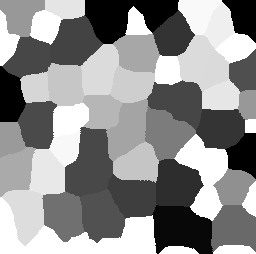

In [86]:
img_up = zeros(RGB, (254, 256));
for i in eachindex(img)
       img_up[i] = seg.segment_means[seg.image_indexmap[i]] +1
end
img_up

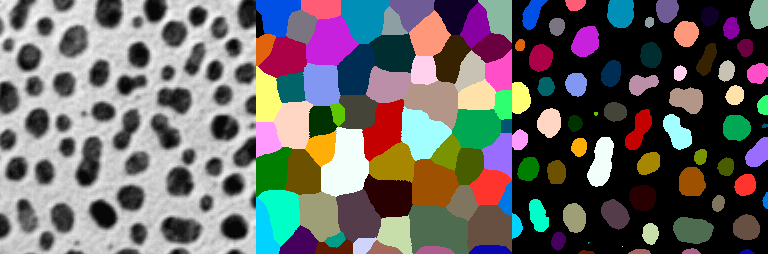

In [90]:
labels = labels_map(seg)
colored_labels = Images.IndirectArray(labels, distinguishable_colors(maximum(labels)))
masked_colored_labels = colored_labels .* (1 .- bw)
mosaic(img, colored_labels, masked_colored_labels; nrow=1)

Check the documentation for more: https://juliaimages.org/latest